In [1]:
import pandas as pd
from os import path
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TextVectorization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from math import pi
from tensorflow.keras.layers import GRU
import numpy as np
import seaborn as sns
import os

# Định nghĩa đường dẫn
DATA_DIR = r"c:\Users\Admin\Python\ABSA_Prompting\data"
RESULT_DIR = r"c:\Users\Admin\Python\ABSA_Prompting\results"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(RESULT_DIR, exist_ok=True)

In [2]:
# CONFIG
ViABSA_BP_dir = path.join(DATA_DIR, 'ViABSA_BP')

train_file = path.join(ViABSA_BP_dir, 'data_train.csv')
test_file = path.join(ViABSA_BP_dir, 'data_test.csv')

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

In [3]:
train_df.head()

,data,stayingpower,texture,smell,price,others,colour,shipping,packing
0,"son đẹp lăm,sẽ ủng hộ tiếp , shipper cũng dễ t...",NaN,NaN,NaN,NaN,NaN,NaN,positive,NaN
1,Son đẹp lắm nha mn tuy là son nội địa giá rẻ n...,NaN,positive,positive,positive,NaN,NaN,NaN,NaN
2,"Son màu lên chuẩn, đẹp tuy nhiên dễ khô nên cầ...",NaN,negative,NaN,NaN,NaN,positive,NaN,NaN
3,Công dụng: rất đẹp\nKết cấu: tốt\nĐộ bền màu: ...,positive,positive,NaN,NaN,NaN,positive,NaN,NaN
4,"Hàng gói siêu chắc chắn, packing xinh xỉu, đủ ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,positive


In [4]:
# SET-UP DATA
aspects = train_df.columns[1:]

train_df[aspects] = train_df[aspects].fillna("none")
test_df[aspects] = test_df[aspects].fillna("none")

for aspect in aspects:
  train_df[aspect + "_label"] = (train_df[aspect] != "none").astype(int)
  test_df[aspect + "_label"] = (test_df[aspect] != "none").astype(int)


aspect_labels = [aspect + "_label" for aspect in aspects]

X_train = train_df['data']
y_train_aspect = train_df[aspect_labels]
X_test = test_df['data']
y_test_aspect = test_df[aspect_labels]

train_df.head()

,data,stayingpower,texture,smell,price,others,colour,shipping,packing,stayingpower_label,texture_label,smell_label,price_label,others_label,colour_label,shipping_label,packing_label
0,"son đẹp lăm,sẽ ủng hộ tiếp , shipper cũng dễ t...",none,none,none,none,none,none,positive,none,0,0,0,0,0,0,1,0
1,Son đẹp lắm nha mn tuy là son nội địa giá rẻ n...,none,positive,positive,positive,none,none,none,none,0,1,1,1,0,0,0,0
2,"Son màu lên chuẩn, đẹp tuy nhiên dễ khô nên cầ...",none,negative,none,none,none,positive,none,none,0,1,0,0,0,1,0,0
3,Công dụng: rất đẹp\nKết cấu: tốt\nĐộ bền màu: ...,positive,positive,none,none,none,positive,none,none,1,1,0,0,0,1,0,0
4,"Hàng gói siêu chắc chắn, packing xinh xỉu, đủ ...",none,none,none,none,none,none,none,positive,0,0,0,0,0,0,0,1


# **BiLSTM**

In [5]:
print(X_train.dtype)
print(y_train_aspect.dtypes)

object
stayingpower_label    int64
texture_label         int64
smell_label           int64
price_label           int64
others_label          int64
colour_label          int64
shipping_label        int64
packing_label         int64
dtype: object


In [6]:
vectorizer = TextVectorization()
vectorizer.adapt(X_train)

X_train_BiLSTM = vectorizer(X_train)
X_test_BiLSTM = vectorizer(X_test)

In [7]:
'''
    Nếu là multi-label (mỗi khía cạnh có thể xuất hiện độc lập) phải dùng activation='sigmoid' ở output layer, không dùng softmax
    softmax chỉ dùng cho multi-class (mỗi mẫu chỉ thuộc 1 lớp)
    - Softmax:
        Dùng cho multi-class (mỗi mẫu chỉ thuộc 1 lớp duy nhất)
        Tổng xác suất các lớp = 1
        Ví dụ: Phân loại cảm xúc (chỉ 1 trong 3: positive, neutral, negative)
    - Sigmoid:
        Dùng cho multi-label (mỗi mẫu có thể thuộc nhiều lớp cùng lúc)
        Mỗi output là xác suất độc lập (0-1) cho từng nhãn
        Ví dụ: Phát hiện các khía cạnh trong 1 câu, mỗi khía cạnh là 1 nhãn độc lập
'''

vocab_size = len(vectorizer.get_vocabulary())

# Cấu hình model BiLSTM
BiLSTM = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100), 
    Bidirectional(LSTM(64)),
    Dense(len(aspect_labels), activation='sigmoid')
])

# Huấn luyện mô hình
# Dùng binary_crossentropy vì đang dùng sigmoid quy y về dạng 0 1
BiLSTM.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
BiLSTM.fit(X_train_BiLSTM, y_train_aspect)

# Dự đoán trên tập test
y_pred_aspect = BiLSTM.predict(X_test_BiLSTM)

406/406 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.2745 - loss: 0.4298
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [8]:
# Chuyển thành nhị phân (threshold 0.5) -> do dùng sigmoid trả về tập hợp từ [0; 1] nhưng y_pred_aspect cần 0 1
# >= 0.5 gán nhãn 1, < 0.5 nhãn 0
y_pred_aspect = (y_pred_aspect >= 0.5).astype(int)

f1_ad = f1_score(y_test_aspect, y_pred_aspect, average='micro')
print(f"\nF1_ad (Aspect Detection): {f1_ad:.4f}")


F1_ad (Aspect Detection): 0.8659


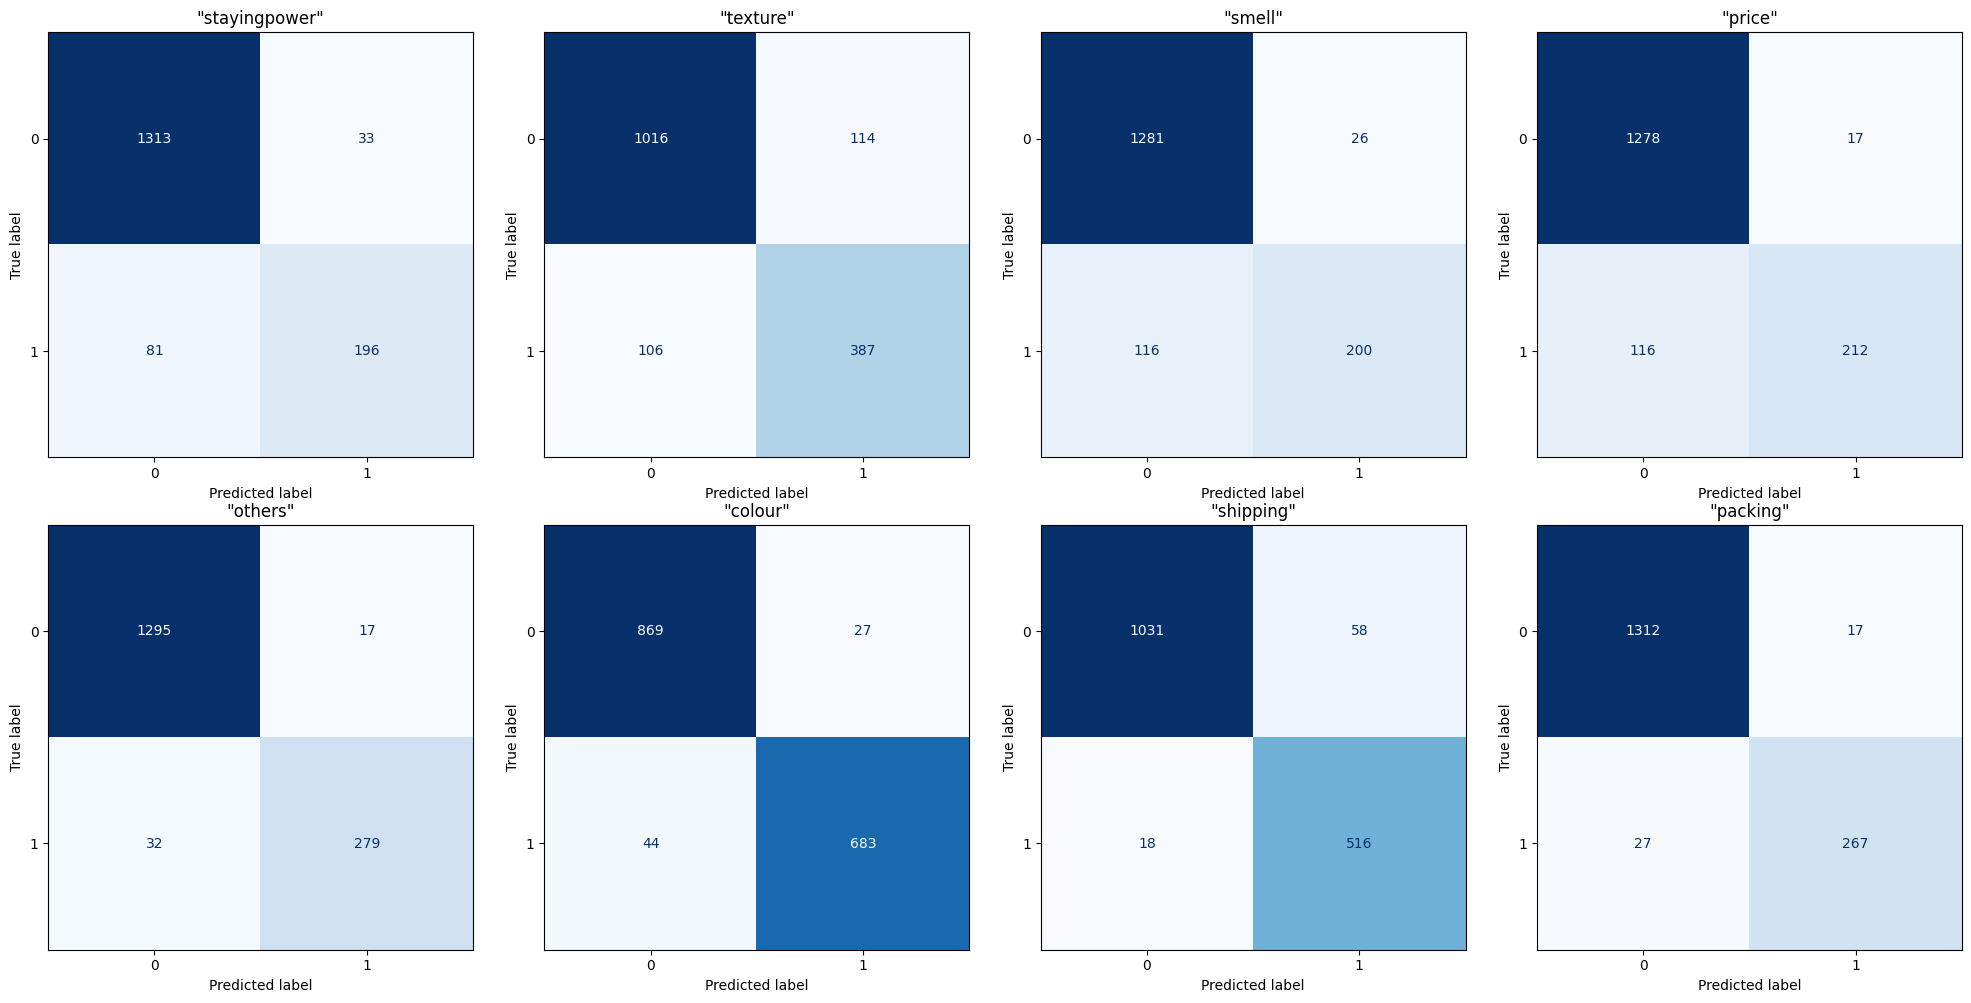

In [9]:
# Số cột mỗi hàng
cols = 4
total = len(aspects)
rows = (total + cols - 1) // cols 

# Tạo subplot grid
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
axes = axes.flatten() 

for i, aspect in enumerate(aspects):
    idx = aspects.get_loc(aspect)
    y_true = y_test_aspect[aspect + '_label']
    y_pred = y_pred_aspect[:, idx]

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f'"{aspect}"')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [10]:
sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2, 'none': -1}

y_train_sentiment = {}
y_test_sentiment = {}

for aspect in aspects:
  y_train_sentiment[aspect] = train_df[aspect].map(sentiment_map).fillna(-1).astype(int)
  y_test_sentiment[aspect] = test_df[aspect].map(sentiment_map).fillna(-1).astype(int)

pipeline_sentiment = {}

for aspect in aspects:
  mask_train = train_df[aspect + '_label'] == 1
  X_train_aspect = train_df[mask_train]
  y_train_aspect_sentiment = y_train_sentiment[aspect][mask_train]

  if len(X_train_aspect) > 0:
    BiLSTM = Sequential([
        vectorizer,
        Embedding(input_dim=vocab_size, output_dim=100),
        Bidirectional(LSTM(64)),
        Dense(3, activation='softmax')])
    
    # Dùng sparse_categorical_crossentropy vì y là số nguyên (0, 1, 2)
    BiLSTM.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    BiLSTM.fit(X_train_aspect['data'].astype(str).values, y_train_aspect_sentiment.values)

    pipeline_sentiment[aspect] = BiLSTM

  else:
    pipeline_sentiment[aspect] = None

70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.5473 - loss: 0.9670
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7201 - loss: 0.7379
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7638 - loss: 0.7133
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9323 - loss: 0.3106
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9562 - loss: 0.2380
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8133 - loss: 0.5786
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7021 - loss: 0.7006
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.9518 - loss: 0.3644


In [11]:
num_samples = len(X_test)
y_pred_sentiment = np.full((num_samples, len(aspects)), -1)

for i, aspect in enumerate(aspects):
    pipe = pipeline_sentiment[aspect]
    if pipe is not None:
        mask_pred = y_pred_aspect[:, i] == 1 
        if np.any(mask_pred):
            # Chuẩn hóa văn bản trước khi predict
            X_test_aspect = X_test[mask_pred].astype(str).values

            # Dự đoán sentiment
            y_pred_prob = pipe.predict(X_test_aspect)
            y_pred_label = np.argmax(y_pred_prob, axis=1)

            # Gán kết quả vào y_pred_sentiment
            y_pred_sentiment[mask_pred, i] = y_pred_label

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


In [12]:
f1_sc_list = []
for i, aspect in enumerate(aspects):
    mask = (y_pred_aspect[:, i] >= 0.5) & (y_test_sentiment[aspect] != -1) 
    if np.sum(mask) > 0:
        f1 = f1_score(
            y_test_sentiment[aspect][mask],
            y_pred_sentiment[mask, i],
            average='weighted'
        )
        f1_sc_list.append(f1)
        print(f"F1_sc ({aspect}): {f1:.4f}")

f1_sc = np.mean(f1_sc_list) if f1_sc_list else 0
print(f"\nF1_sc (Sentiment Classification, trung bình): {f1_sc:.4f}")

F1_sc (stayingpower): 0.5795
F1_sc (texture): 0.7557
F1_sc (smell): 0.7928
F1_sc (price): 0.9929
F1_sc (others): 1.0000
F1_sc (colour): 0.8139
F1_sc (shipping): 0.8969
F1_sc (packing): 0.9386

F1_sc (Sentiment Classification, trung bình): 0.8463


In [13]:
# F1_ad: F1-score trung bình trên tất cả các khía cạnh (multi-label)
f1_ad = f1_score(y_test_aspect, y_pred_aspect, average='micro')

# F1_sc: F1-score trung bình trên tất cả các khía cạnh và cảm xúc (chỉ tính trên các khía cạnh được dự đoán và có nhãn cảm xúc hợp lệ)
f1_sc_list = []
for i, aspect in enumerate(aspects):
    # Chọn mẫu có khía cạnh được dự đoán và có nhãn cảm xúc hợp lệ (khác -1)
    mask = (y_pred_aspect[:, i] == 1) & (y_test_sentiment[aspect] != -1)
    if np.sum(mask) > 0:
        f1 = f1_score(
            y_test_sentiment[aspect][mask],
            y_pred_sentiment[mask, i],
            average='weighted'
        )
        f1_sc_list.append(f1)

In [14]:
# Kết quả 
f1_sc = np.mean(f1_sc_list) if f1_sc_list else 0

print(f"F1_ad (Aspect Detection): {f1_ad:.4f}")
print(f"F1_sc (Sentiment Classification): {f1_sc:.4f}")

F1_ad (Aspect Detection): 0.8659
F1_sc (Sentiment Classification): 0.8463



Confusion matrix cho khía cạnh 'stayingpower':


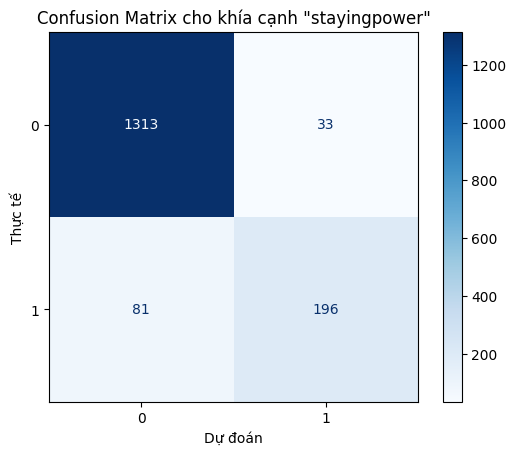


Confusion matrix cho khía cạnh 'texture':


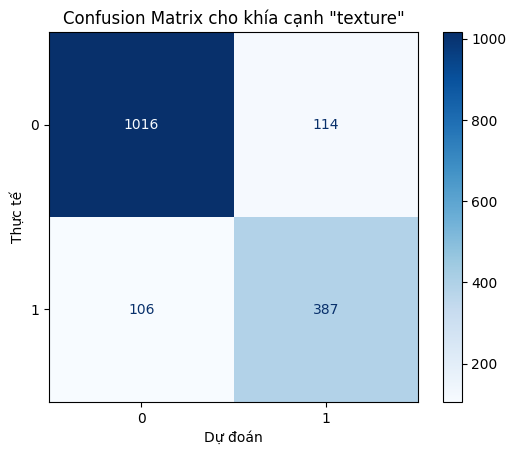


Confusion matrix cho khía cạnh 'smell':


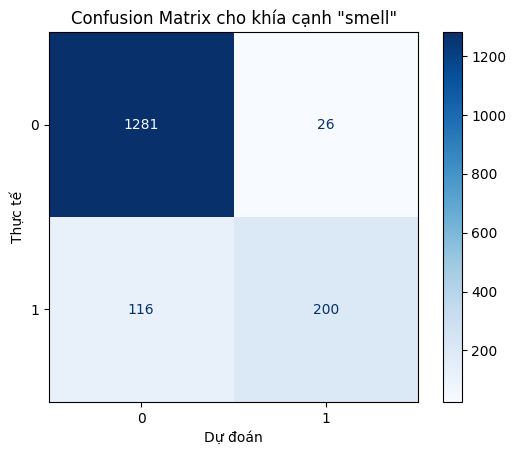


Confusion matrix cho khía cạnh 'price':


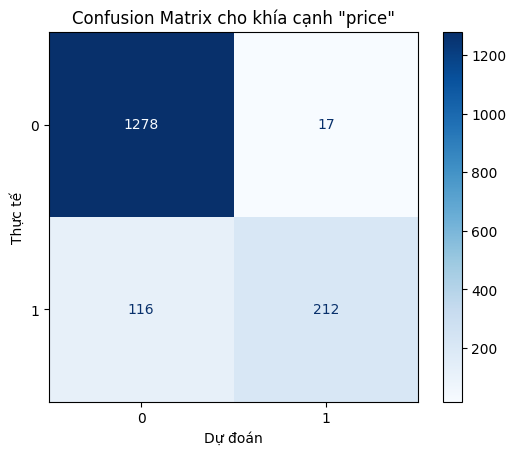


Confusion matrix cho khía cạnh 'others':


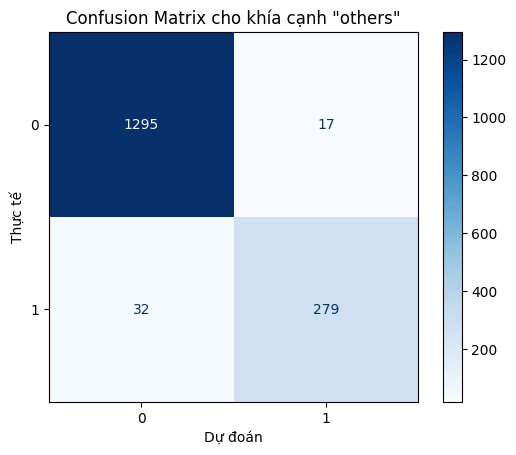


Confusion matrix cho khía cạnh 'colour':


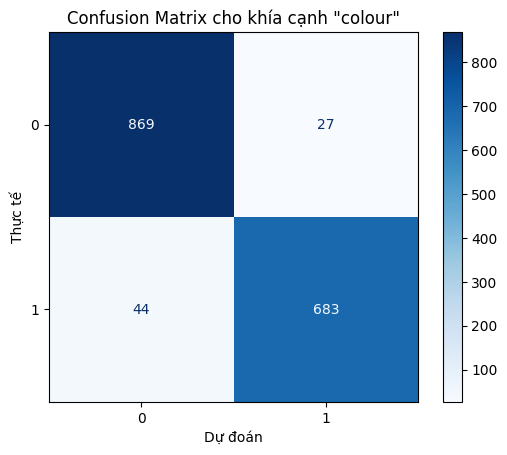


Confusion matrix cho khía cạnh 'shipping':


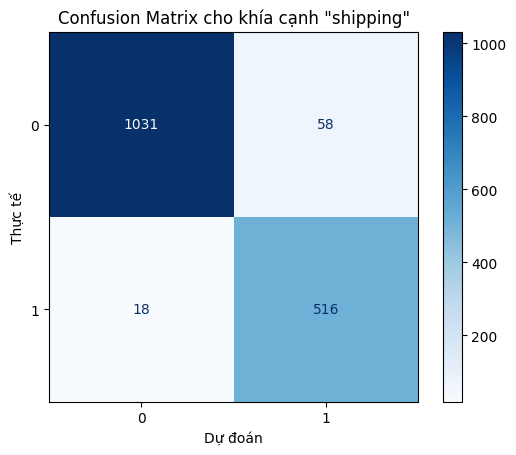


Confusion matrix cho khía cạnh 'packing':


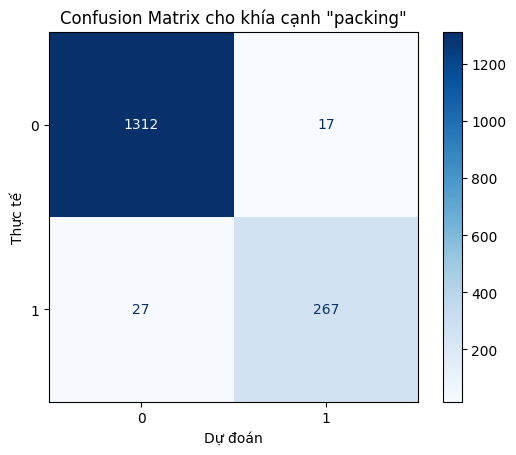

In [15]:
for aspect in aspects:
    idx = aspects.get_loc(aspect)  # nếu aspects là pandas.Index; dùng .index(aspect) nếu là list

    print(f"\nConfusion matrix cho khía cạnh '{aspect}':")

    y_true = y_test_aspect[aspect + '_label']
    y_pred = y_pred_aspect[:, idx]

    # Tính confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # Hiển thị matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix cho khía cạnh \"{aspect}\"')
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.show()

# **BiGRU**

In [16]:
vectorizer = TextVectorization()
vectorizer.adapt(X_train)

X_train_BiGRU = vectorizer(X_train)
X_test_BiGRU = vectorizer(X_test)

In [17]:
vocab_size = len(vectorizer.get_vocabulary())

# Cấu hình BiGRU
BiGRU = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100),
    Bidirectional(GRU(64)),
    Dense(len(aspect_labels), activation='sigmoid')
])

# Huấn luyện
BiGRU.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
BiGRU.fit(X_train_BiGRU, y_train_aspect)

# Dự đoán trên tập test
y_pred_aspect = BiGRU.predict(X_test_BiGRU)

406/406 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - accuracy: 0.2874 - loss: 0.4313
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [18]:
# Tính f1_score
y_pred_aspect = (y_pred_aspect >= 0.5).astype(int)

f1_ad = f1_score(y_test_aspect, y_pred_aspect, average='micro')
print(f"\nF1_ad (Aspect Detection): {f1_ad:.4f}")


F1_ad (Aspect Detection): 0.8052


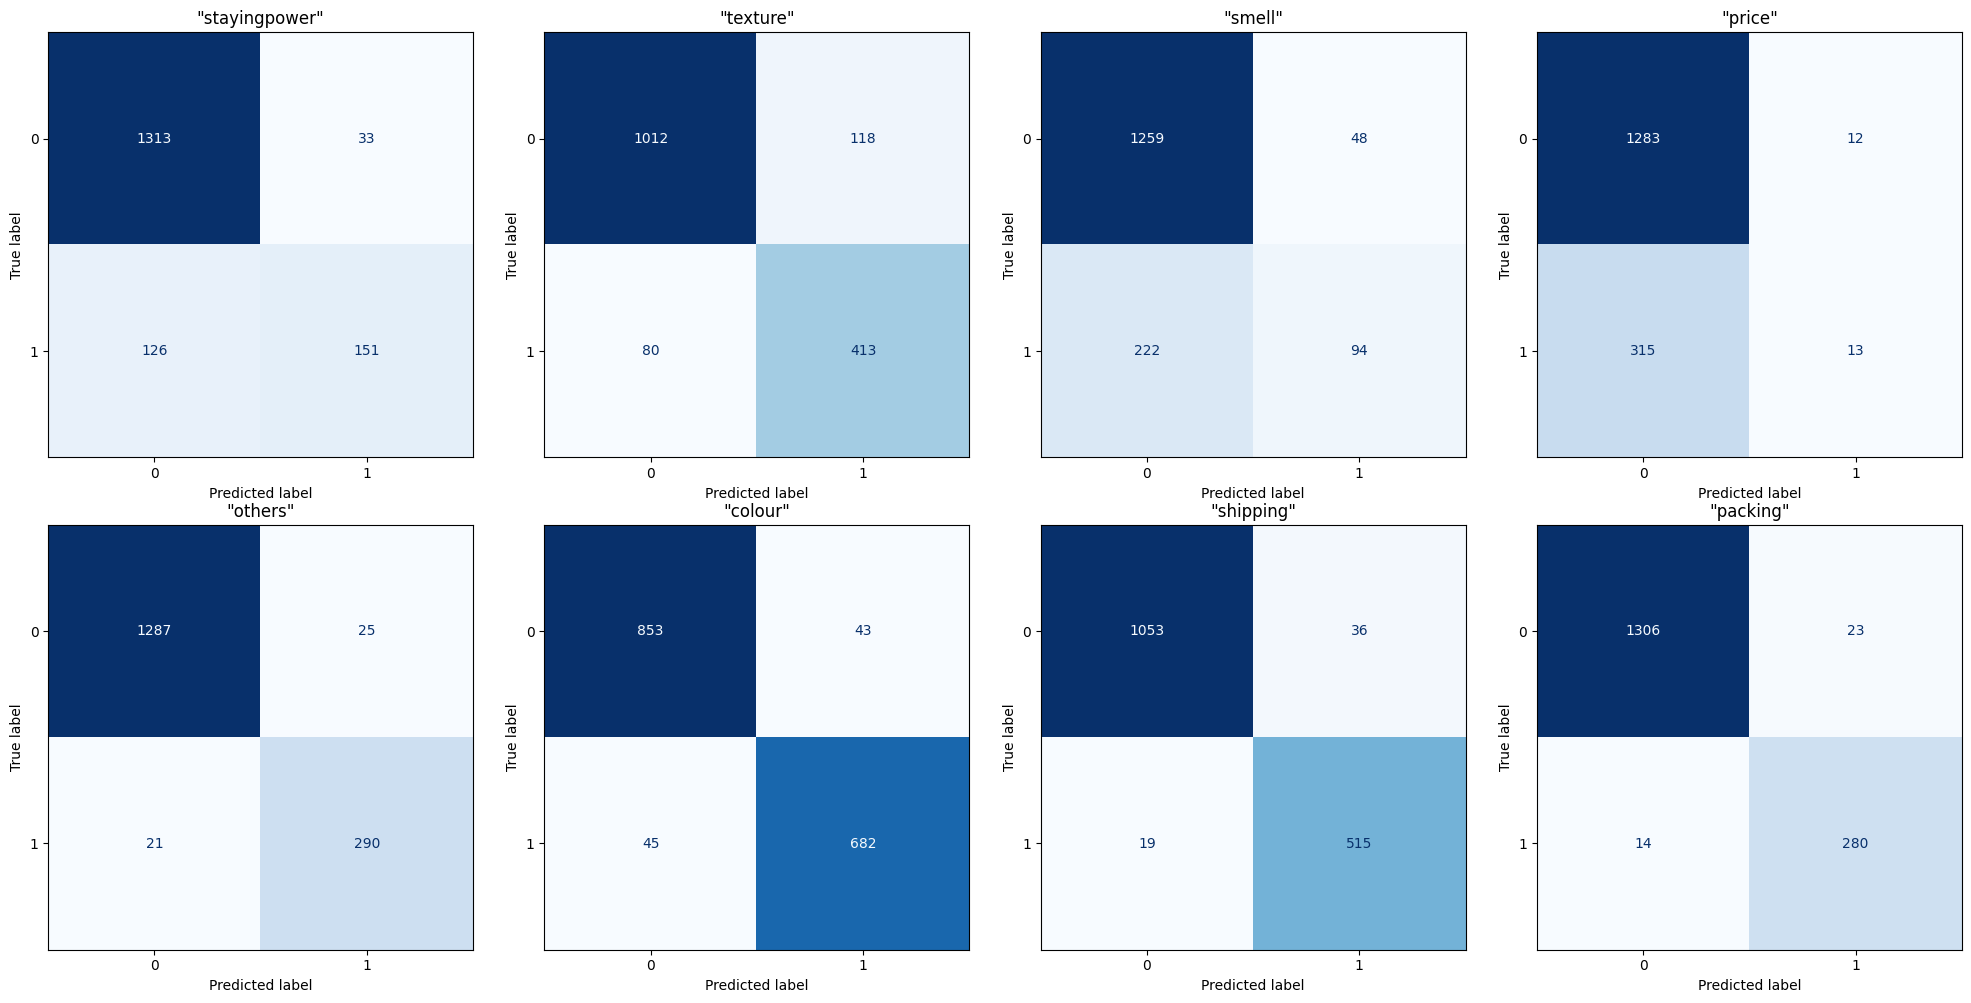

In [19]:
# Số cột mỗi hàng
cols = 4
total = len(aspects)
rows = (total + cols - 1) // cols 

# Tạo subplot grid
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
axes = axes.flatten() 

for i, aspect in enumerate(aspects):
    idx = aspects.get_loc(aspect)
    y_true = y_test_aspect[aspect + '_label']
    y_pred = y_pred_aspect[:, idx]

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f'"{aspect}"')

# Tắt các ô trống nếu số khía cạnh không chia hết cho 4
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [20]:
sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2, 'none': -1}

y_train_sentiment = {}
y_test_sentiment = {}

for aspect in aspects:
  y_train_sentiment[aspect] = train_df[aspect].map(sentiment_map).fillna(-1).astype(int)
  y_test_sentiment[aspect] = test_df[aspect].map(sentiment_map).fillna(-1).astype(int)

pipeline_sentiment = {}

for aspect in aspects:
  mask_train = train_df[aspect + '_label'] == 1
  X_train_aspect = train_df[mask_train]
  y_train_aspect_sentiment = y_train_sentiment[aspect][mask_train]

  if len(X_train_aspect) > 0:
    BiGRU = Sequential([
        vectorizer,
        Embedding(input_dim=vocab_size, output_dim=100),
        Bidirectional(GRU(64)),
        Dense(3, activation='softmax')])
    
    # Dùng sparse_categorical_crossentropy vì y là số nguyên (0, 1, 2)
    BiGRU.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    BiGRU.fit(X_train_aspect['data'].astype(str).values, y_train_aspect_sentiment.values)

    pipeline_sentiment[aspect] = BiGRU

  else:
    pipeline_sentiment[aspect] = None

70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.5387 - loss: 0.9619
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.6968 - loss: 0.7771
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.7611 - loss: 0.7227
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.9824 - loss: 0.3289
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.9332 - loss: 0.2933
189/189 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.8123 - loss: 0.5973
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.6925 - loss: 0.7212
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9326 - loss: 0.4312


In [21]:
num_samples = len(X_test)
y_pred_sentiment = np.full((num_samples, len(aspects)), -1)

for i, aspect in enumerate(aspects):
    pipe = pipeline_sentiment[aspect]
    if pipe is not None:
        mask_pred = y_pred_aspect[:, i] == 1 
        if np.any(mask_pred):
            # Chuẩn hóa văn bản trước khi predict
            X_test_aspect = X_test[mask_pred].astype(str).values

            # Dự đoán sentiment
            y_pred_prob = pipe.predict(X_test_aspect)
            y_pred_label = np.argmax(y_pred_prob, axis=1)

            # Gán kết quả vào y_pred_sentiment
            y_pred_sentiment[mask_pred, i] = y_pred_label

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


In [22]:
f1_sc_list = []
for i, aspect in enumerate(aspects):
    mask = (y_pred_aspect[:, i] >= 0.5) & (y_test_sentiment[aspect] != -1) 
    if np.sum(mask) > 0:
        f1 = f1_score(
            y_test_sentiment[aspect][mask],
            y_pred_sentiment[mask, i],
            average='weighted'
        )
        f1_sc_list.append(f1)
        print(f"F1_sc ({aspect}): {f1:.4f}")

f1_sc = np.mean(f1_sc_list) if f1_sc_list else 0
print(f"\nF1_sc (Sentiment Classification, trung bình): {f1_sc:.4f}")

F1_sc (stayingpower): 0.5263
F1_sc (texture): 0.7674
F1_sc (smell): 0.8281
F1_sc (price): 1.0000
F1_sc (others): 1.0000
F1_sc (colour): 0.8143
F1_sc (shipping): 0.8783
F1_sc (packing): 0.9415

F1_sc (Sentiment Classification, trung bình): 0.8445


In [23]:
f1_ad = f1_score(y_test_aspect, y_pred_aspect, average='micro')

f1_sc_list = []
for i, aspect in enumerate(aspects):
    mask = (y_pred_aspect[:, i] == 1) & (y_test_sentiment[aspect] != -1)
    if np.sum(mask) > 0:
        f1 = f1_score(
            y_test_sentiment[aspect][mask],
            y_pred_sentiment[mask, i],
            average='weighted'
        )
        f1_sc_list.append(f1)

In [24]:
# Kết quả 
f1_sc = np.mean(f1_sc_list) if f1_sc_list else 0

print(f"F1_ad (Aspect Detection): {f1_ad:.4f}")
print(f"F1_sc (Sentiment Classification): {f1_sc:.4f}")

F1_ad (Aspect Detection): 0.8052
F1_sc (Sentiment Classification): 0.8445



Confusion matrix cho khía cạnh 'stayingpower':


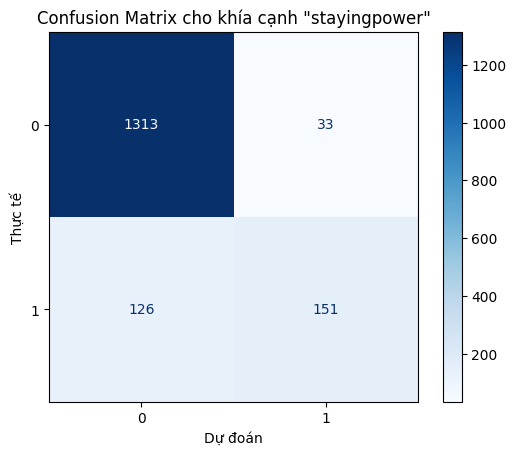


Confusion matrix cho khía cạnh 'texture':


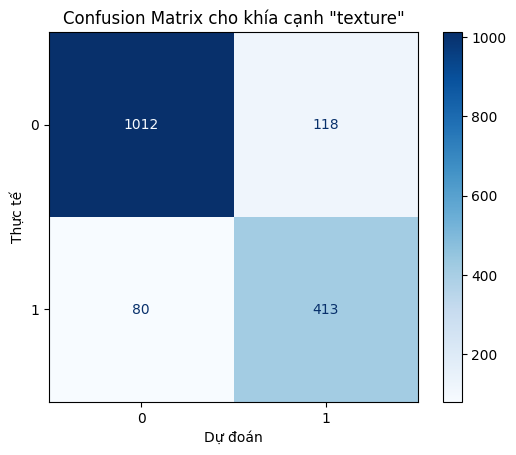


Confusion matrix cho khía cạnh 'smell':


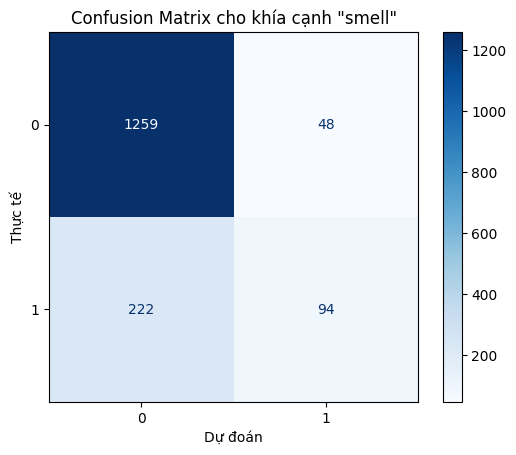


Confusion matrix cho khía cạnh 'price':


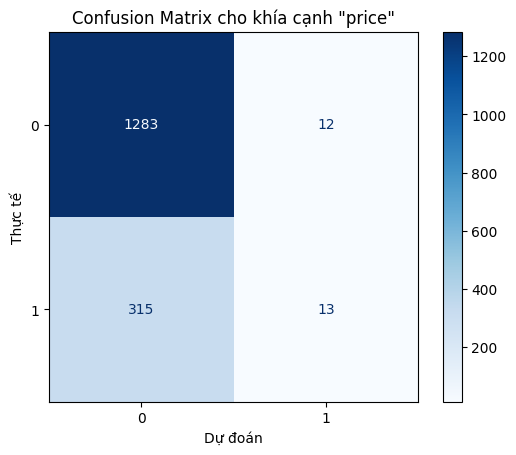


Confusion matrix cho khía cạnh 'others':


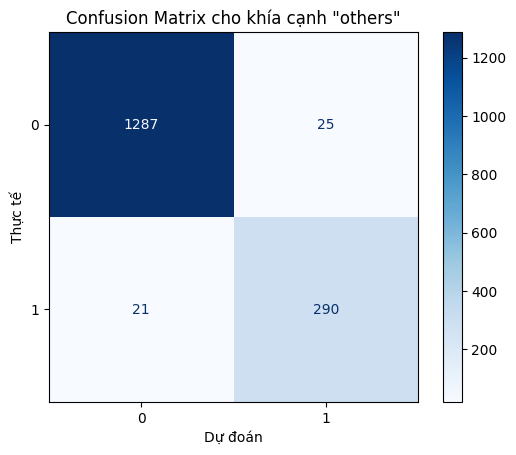


Confusion matrix cho khía cạnh 'colour':


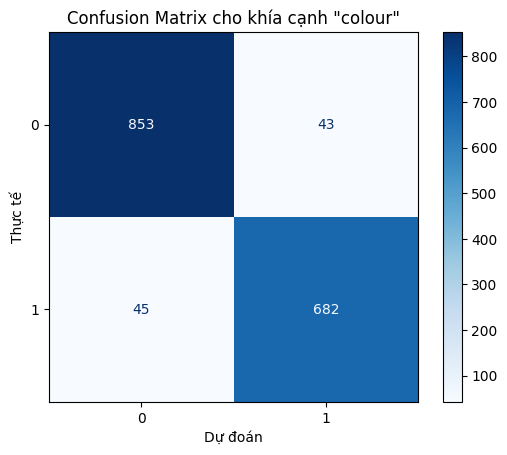


Confusion matrix cho khía cạnh 'shipping':


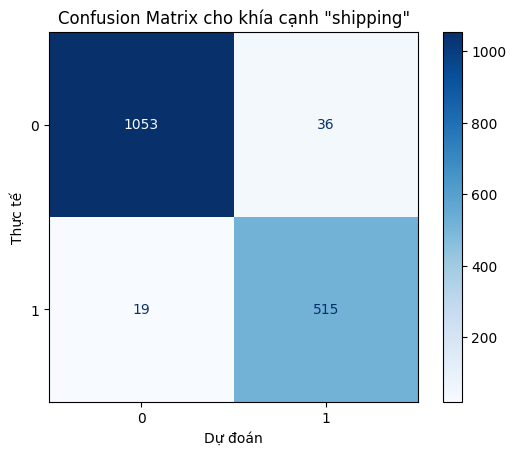


Confusion matrix cho khía cạnh 'packing':


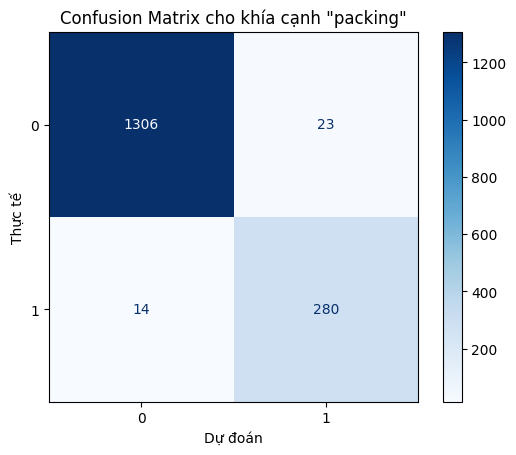

In [25]:
for aspect in aspects:
    idx = aspects.get_loc(aspect)  # nếu aspects là pandas.Index; dùng .index(aspect) nếu là list

    print(f"\nConfusion matrix cho khía cạnh '{aspect}':")

    y_true = y_test_aspect[aspect + '_label']
    y_pred = y_pred_aspect[:, idx]

    # Tính confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # Hiển thị matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix cho khía cạnh \"{aspect}\"')
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.show()

# **BiLSTM + Conv1D**

In [26]:
vectorizer = TextVectorization()
vectorizer.adapt(X_train)

X_train_BiLSTM_Conv1D = vectorizer(X_train)
X_test_BiLSTM_Conv1D = vectorizer(X_test)

In [27]:
vocab_size = len(vectorizer.get_vocabulary())

# Cấu hình model: Embedding → BiLSTM → Conv1D → Dense
BiLSTM_Conv1D = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100),
    
    # Trả về chuỗi đầu ra (nếu dùng Conv1D sau)
    Bidirectional(LSTM(64, return_sequences=True)),  
    
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    
    Dense(64, activation='relu'), # học đặc trưng phức tạp từ output trước 
    Dense(len(aspect_labels), activation='sigmoid') # lớp đầu ra trả về xác suất dự đoán cho từng khía cạnh
])


BiLSTM_Conv1D.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
BiLSTM_Conv1D.fit(X_train_BiLSTM_Conv1D, y_train_aspect)

# Dự đoán trên tập test
y_pred_aspect = BiLSTM_Conv1D.predict(X_test_BiLSTM_Conv1D)

406/406 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - accuracy: 0.2872 - loss: 0.4106
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [28]:
y_pred_aspect = (y_pred_aspect >= 0.5).astype(int)

f1_ad = f1_score(y_test_aspect, y_pred_aspect, average='micro')
print(f"\nF1_ad (Aspect Detection): {f1_ad:.4f}")


F1_ad (Aspect Detection): 0.9353


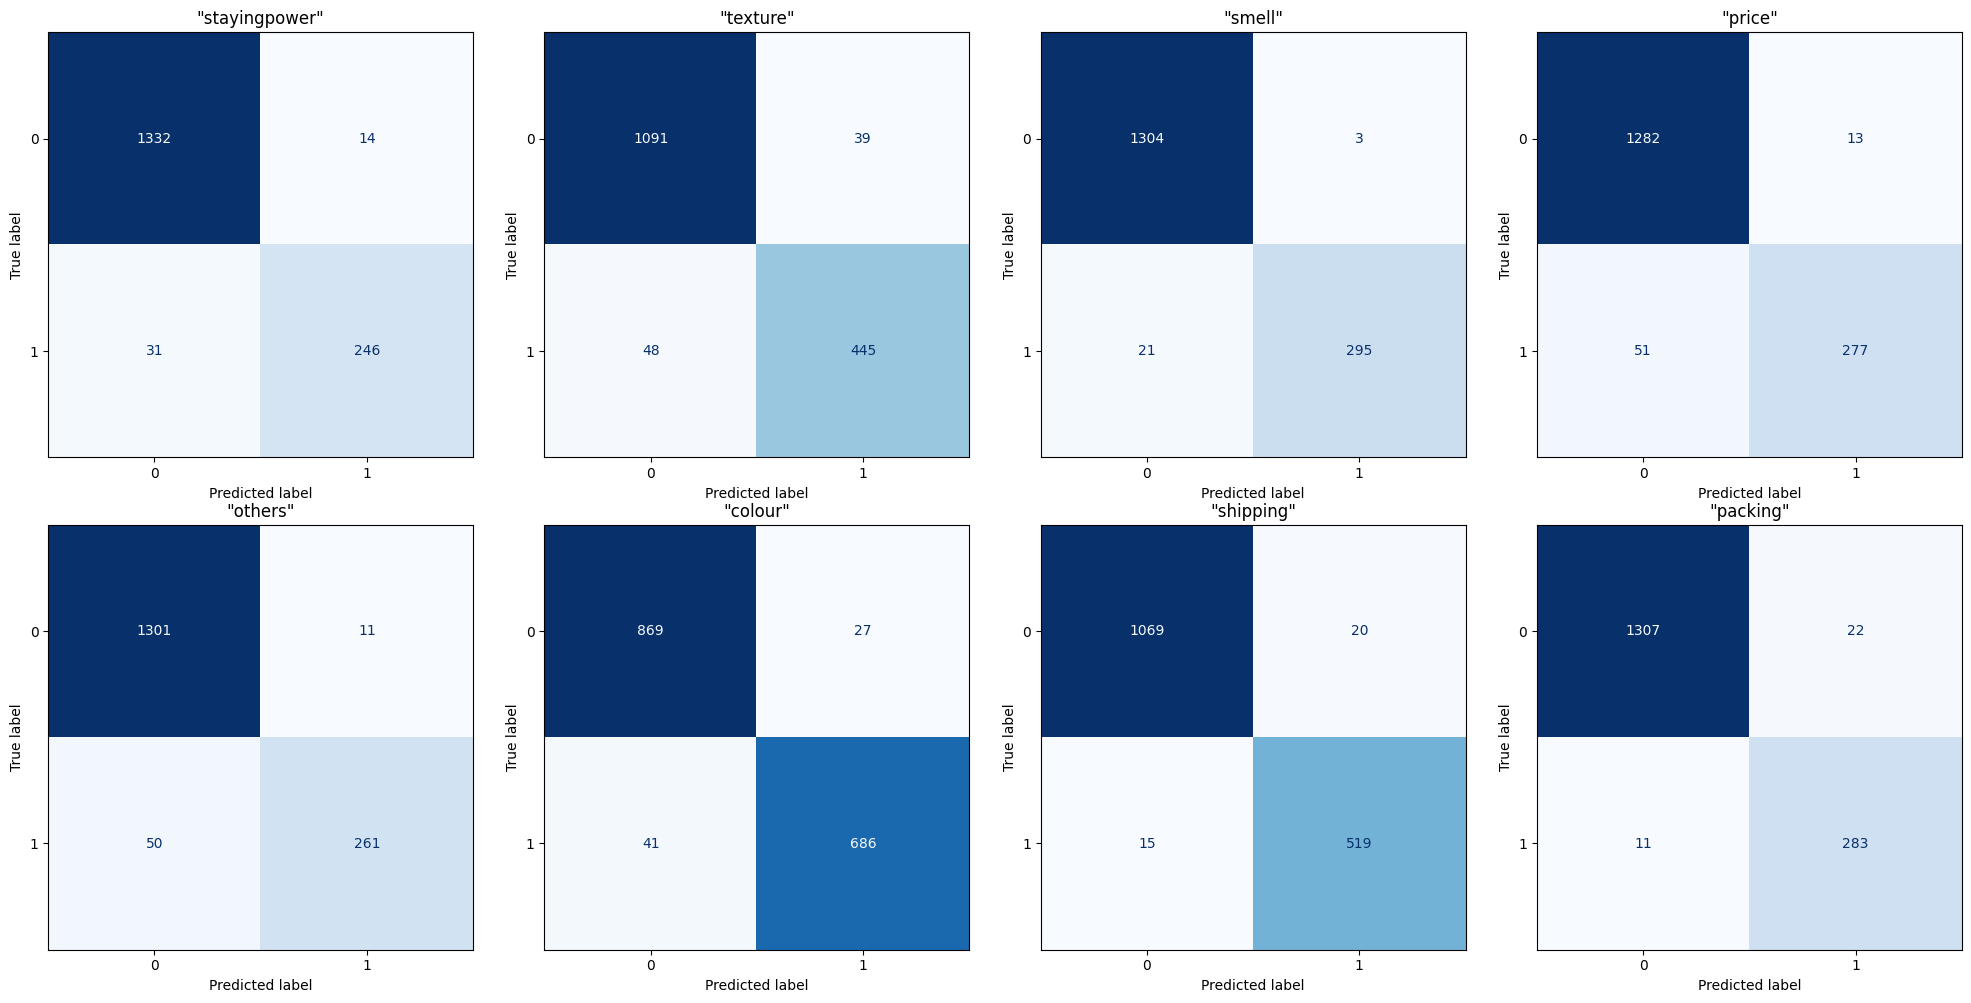

In [29]:
# Số cột mỗi hàng
cols = 4
total = len(aspects)
rows = (total + cols - 1) // cols 

# Tạo subplot grid
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
axes = axes.flatten() 

for i, aspect in enumerate(aspects):
    idx = aspects.get_loc(aspect)
    y_true = y_test_aspect[aspect + '_label']
    y_pred = y_pred_aspect[:, idx]

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f'"{aspect}"')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [30]:
sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2, 'none': -1}

y_train_sentiment = {}
y_test_sentiment = {}

for aspect in aspects:
  y_train_sentiment[aspect] = train_df[aspect].map(sentiment_map).fillna(-1).astype(int)
  y_test_sentiment[aspect] = test_df[aspect].map(sentiment_map).fillna(-1).astype(int)

pipeline_sentiment = {}

for aspect in aspects:
  mask_train = train_df[aspect + '_label'] == 1
  X_train_aspect = train_df[mask_train]
  y_train_aspect_sentiment = y_train_sentiment[aspect][mask_train]

  if len(X_train_aspect) > 0:
    BiLSTM_Conv1D = Sequential([
        vectorizer,
        Embedding(input_dim=vocab_size, output_dim=100),

        Bidirectional(LSTM(64, return_sequences = True)),

        Conv1D(filters=64, kernel_size=3, activation='relu'),
        GlobalMaxPooling1D(),

        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    
    # Dùng sparse_categorical_crossentropy vì y là số nguyên (0, 1, 2)
    BiLSTM_Conv1D.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    BiLSTM_Conv1D.fit(X_train_aspect['data'].astype(str).values, y_train_aspect_sentiment.values)

    pipeline_sentiment[aspect] = BiLSTM_Conv1D

  else:
    pipeline_sentiment[aspect] = None

70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.5191 - loss: 0.9708
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.7145 - loss: 0.7824
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8043 - loss: 0.7074
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9366 - loss: 0.3131
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9332 - loss: 0.2671
189/189 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.8096 - loss: 0.6291
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.7401 - loss: 0.6763
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9634 - loss: 0.3950


In [31]:
f1_sc_list = []
for i, aspect in enumerate(aspects):
    mask = (y_pred_aspect[:, i] >= 0.5) & (y_test_sentiment[aspect] != -1) 
    if np.sum(mask) > 0:
        f1 = f1_score(
            y_test_sentiment[aspect][mask],
            y_pred_sentiment[mask, i],
            average='weighted'
        )
        f1_sc_list.append(f1)
        print(f"F1_sc ({aspect}): {f1:.4f}")

f1_sc = np.mean(f1_sc_list) if f1_sc_list else 0
print(f"\nF1_sc (Sentiment Classification, trung bình): {f1_sc:.4f}")

F1_sc (stayingpower): 0.3891
F1_sc (texture): 0.7235
F1_sc (smell): 0.4010
F1_sc (price): 0.0764
F1_sc (others): 1.0000
F1_sc (colour): 0.8035
F1_sc (shipping): 0.8758
F1_sc (packing): 0.9348

F1_sc (Sentiment Classification, trung bình): 0.6505


In [32]:
f1_ad = f1_score(y_test_aspect, y_pred_aspect, average='micro')

f1_sc_list = []
for i, aspect in enumerate(aspects):
    mask = (y_pred_aspect[:, i] == 1) & (y_test_sentiment[aspect] != -1)
    if np.sum(mask) > 0:
        f1 = f1_score(
            y_test_sentiment[aspect][mask],
            y_pred_sentiment[mask, i],
            average='weighted'
        )
        f1_sc_list.append(f1)

In [33]:
# Kết quả 
f1_sc = np.mean(f1_sc_list) if f1_sc_list else 0

print(f"F1_ad (Aspect Detection): {f1_ad:.4f}")
print(f"F1_sc (Sentiment Classification): {f1_sc:.4f}")

F1_ad (Aspect Detection): 0.9353
F1_sc (Sentiment Classification): 0.6505



Confusion matrix cho khía cạnh 'stayingpower':


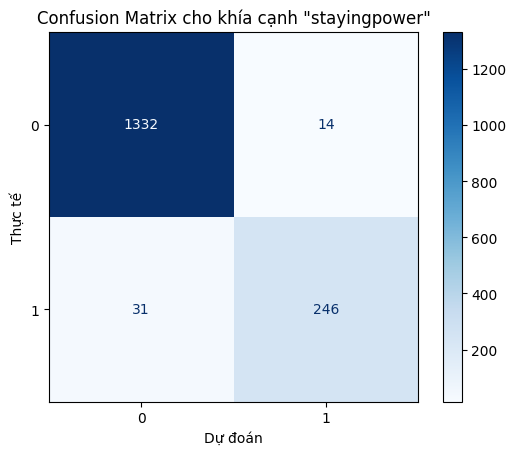


Confusion matrix cho khía cạnh 'texture':


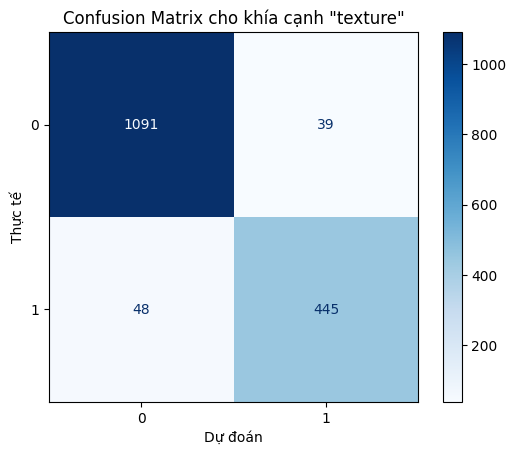


Confusion matrix cho khía cạnh 'smell':


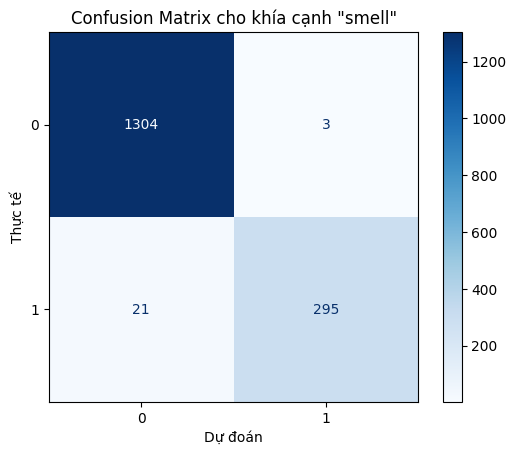


Confusion matrix cho khía cạnh 'price':


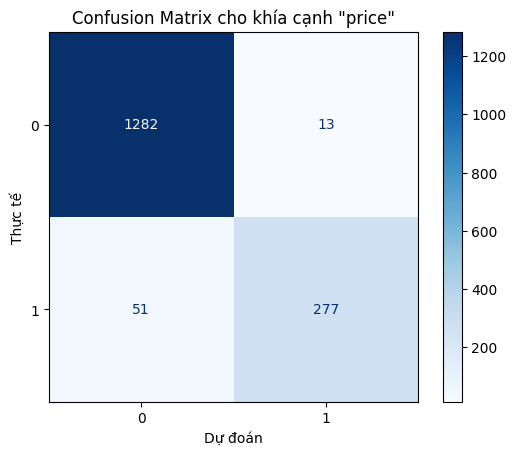


Confusion matrix cho khía cạnh 'others':


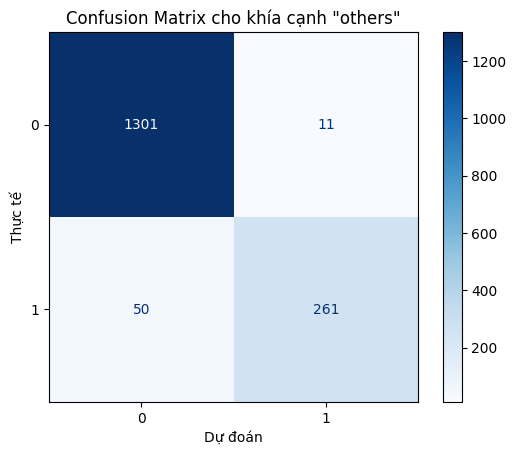


Confusion matrix cho khía cạnh 'colour':


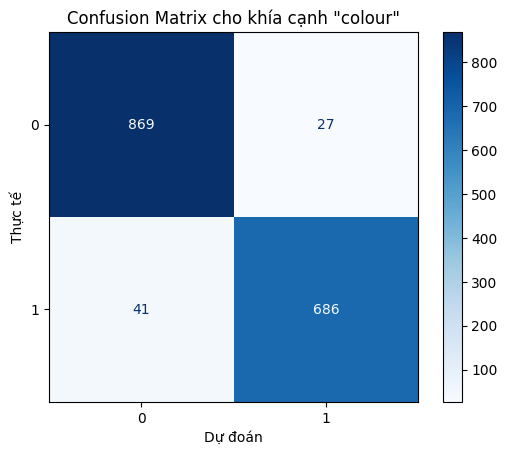


Confusion matrix cho khía cạnh 'shipping':


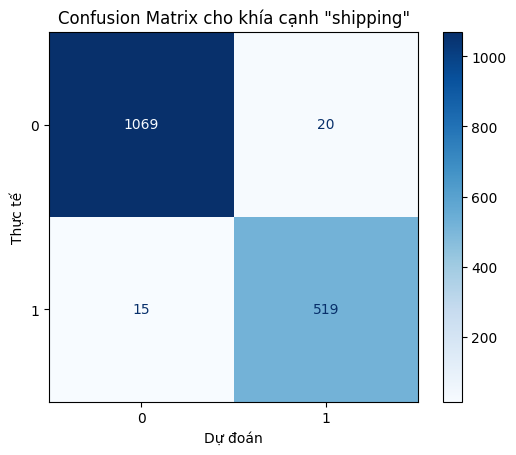


Confusion matrix cho khía cạnh 'packing':


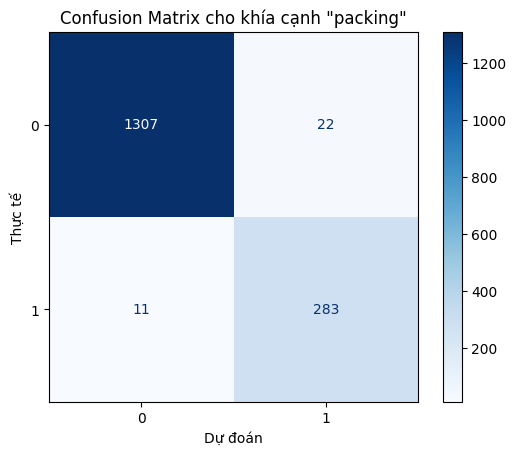

In [34]:
for aspect in aspects:
    idx = aspects.get_loc(aspect)  # nếu aspects là pandas.Index; dùng .index(aspect) nếu là list

    print(f"\nConfusion matrix cho khía cạnh '{aspect}':")

    y_true = y_test_aspect[aspect + '_label']
    y_pred = y_pred_aspect[:, idx]

    # Tính confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # Hiển thị matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix cho khía cạnh \"{aspect}\"')
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.show()